In [13]:
import os
import polars as pl
import numpy as np
import datetime as dt
import aacgmv2
import contextlib
from spacepy import pycdf
import matplotlib.pyplot as plt

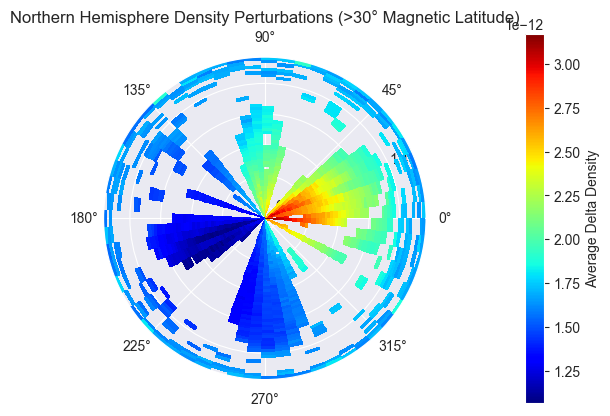

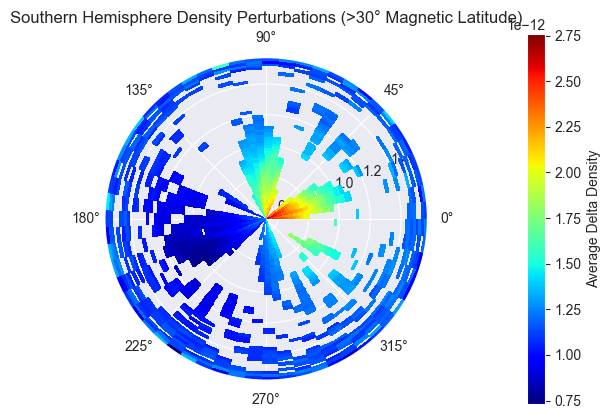

In [38]:
import os
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

# Directory with saved CSV files
champ_dir = "/Users/patrick/Dev/perceptive_techeval/champ_l2/"

# Define latitude bins from 30 to 90 degrees and MLT (0 to 24 hours)
lat_bins = np.deg2rad(np.linspace(30, 90, 60))  # Radial bins from 30 to 90 degrees for both hemispheres
mlt_bins = np.linspace(0, 2 * np.pi, 60)  # MLT from 0 to 24 hours in radians

# Initialize histograms for North and South Hemispheres
north_hist = np.zeros((len(mlt_bins) - 1, len(lat_bins) - 1))
south_hist = np.zeros((len(mlt_bins) - 1, len(lat_bins) - 1))
north_counts = np.zeros_like(north_hist)
south_counts = np.zeros_like(south_hist)

# Process each CSV file
for file in os.listdir(champ_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(champ_dir, file)
        
        # Load the CSV into a polars DataFrame
        df = pl.read_csv(file_path)
        df = df.drop_nulls(subset=["geomagnetic_latitude", "mlt", "delta_density"])
        
        # Filter for Northern and Southern Hemispheres within 30-90° range
        df_north = df.filter((pl.col("geomagnetic_latitude") >= 30) & (pl.col("geomagnetic_latitude") <= 90))
        df_south = df.filter((pl.col("geomagnetic_latitude") <= -30) & (pl.col("geomagnetic_latitude") >= -90))

        # Convert geomagnetic latitude to radians and MLT to radians
        geom_lat_north_radians = np.deg2rad(df_north["geomagnetic_latitude"].to_numpy())
        mlt_north_radians = (df_north["mlt"].to_numpy() / 24) * 2 * np.pi
        geom_lat_south_radians = np.deg2rad(np.abs(df_south["geomagnetic_latitude"].to_numpy()))  # Convert to positive
        mlt_south_radians = (df_south["mlt"].to_numpy() / 24) * 2 * np.pi

        # Calculate 2D histograms with delta_density as weights
        hist_north, _, _ = np.histogram2d(mlt_north_radians, geom_lat_north_radians, bins=(mlt_bins, lat_bins), 
                                          weights=df_north["density"].to_numpy())
        counts_north, _, _ = np.histogram2d(mlt_north_radians, geom_lat_north_radians, bins=(mlt_bins, lat_bins))
        
        hist_south, _, _ = np.histogram2d(mlt_south_radians, geom_lat_south_radians, bins=(mlt_bins, lat_bins), 
                                          weights=df_south["density"].to_numpy())
        counts_south, _, _ = np.histogram2d(mlt_south_radians, geom_lat_south_radians, bins=(mlt_bins, lat_bins))
        
        # Accumulate histograms
        north_hist += hist_north
        south_hist += hist_south
        north_counts += counts_north
        south_counts += counts_south

# Compute average delta_density for each bin by dividing by counts (avoiding division by zero)
avg_north_density = np.divide(north_hist, north_counts, out=np.zeros_like(north_hist), where=north_counts != 0)
avg_south_density = np.divide(south_hist, south_counts, out=np.zeros_like(south_hist), where=south_counts != 0)

# Define mesh grid for polar plot
A_north, R_north = np.meshgrid(mlt_bins, lat_bins)
A_south, R_south = np.meshgrid(mlt_bins, lat_bins)

# Plot for Northern Hemisphere
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
ax.set_ylim(np.deg2rad(30), np.deg2rad(90))  # Range from 30° to 90° for magnetic latitudes

pc = ax.pcolormesh(A_north, R_north, avg_north_density.T, cmap="jet")
fig.colorbar(pc, ax=ax, label="Average Delta Density", pad=.2)
ax.set_title("Northern Hemisphere Density Perturbations (>30° Magnetic Latitude)")

# Plot for Southern Hemisphere
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
ax.set_ylim(np.deg2rad(30), np.deg2rad(90))  # Range from 30° to 90° for magnetic latitudes

pc = ax.pcolormesh(A_south, R_south, avg_south_density.T, cmap="jet")
fig.colorbar(pc, ax=ax, label="Average Delta Density", pad=.2)
ax.set_title("Southern Hemisphere Density Perturbations (>30° Magnetic Latitude)")

plt.show()


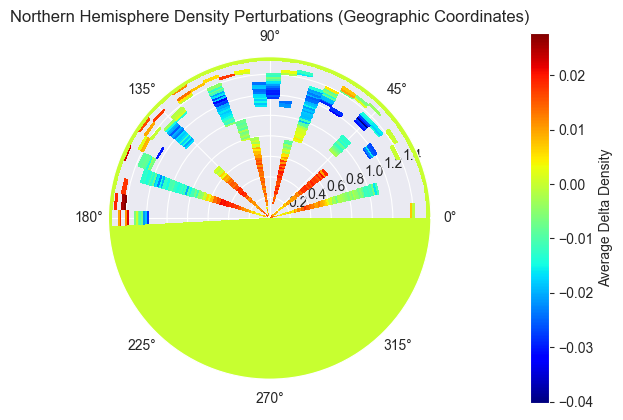

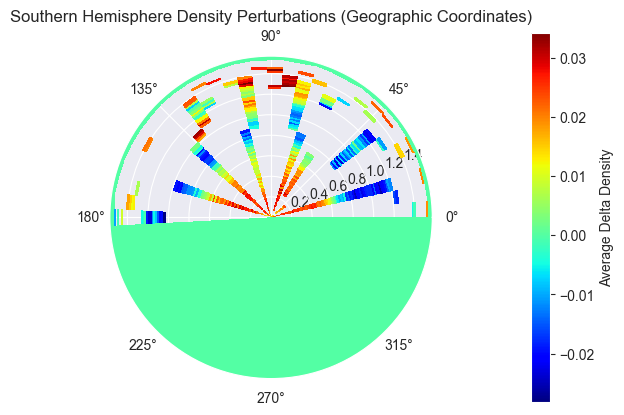

In [35]:
import os
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

# Directory with saved CSV files
champ_dir = "/Users/patrick/Dev/perceptive_techeval/champ_l2/"

# Define latitude bins (0 to 90 degrees) and longitude bins (0 to 360 degrees)
lat_bins = np.deg2rad(np.linspace(0, 90, 90))  # Radial bins from 0 to 90 degrees for both hemispheres
lon_bins = np.linspace(0, 2 * np.pi, 60)  # Longitude from 0 to 360 degrees in radians

# Initialize histograms for North and South Hemispheres
north_hist = np.zeros((len(lon_bins) - 1, len(lat_bins) - 1))
south_hist = np.zeros((len(lon_bins) - 1, len(lat_bins) - 1))
north_counts = np.zeros_like(north_hist)
south_counts = np.zeros_like(south_hist)

# Process each CSV file
for file in os.listdir(champ_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(champ_dir, file)
        
        # Load the CSV into a polars DataFrame
        df = pl.read_csv(file_path)
        
        # Filter for Northern and Southern Hemispheres within 0-90° range
        df_north = df.filter((pl.col("latitude") >= 0) & (pl.col("latitude") <= 90))
        df_south = df.filter((pl.col("latitude") < 0) & (pl.col("latitude") >= -90))

        # Convert latitude to radians and longitude to radians
        lat_north_radians = np.deg2rad(df_north["latitude"].to_numpy())
        lon_north_radians = np.deg2rad(df_north["longitude"].to_numpy())
        lat_south_radians = np.deg2rad(np.abs(df_south["latitude"].to_numpy()))  # Convert to positive for plotting
        lon_south_radians = np.deg2rad(df_south["longitude"].to_numpy())

        # Calculate 2D histograms with delta_density as weights
        hist_north, _, _ = np.histogram2d(lon_north_radians, lat_north_radians, bins=(lon_bins, lat_bins), 
                                          weights=df_north["delta_density"].to_numpy())
        counts_north, _, _ = np.histogram2d(lon_north_radians, lat_north_radians, bins=(lon_bins, lat_bins))
        
        hist_south, _, _ = np.histogram2d(lon_south_radians, lat_south_radians, bins=(lon_bins, lat_bins), 
                                          weights=df_south["delta_density"].to_numpy())
        counts_south, _, _ = np.histogram2d(lon_south_radians, lat_south_radians, bins=(lon_bins, lat_bins))
        
        # Accumulate histograms
        north_hist += hist_north
        south_hist += hist_south
        north_counts += counts_north
        south_counts += counts_south

# Compute average delta_density for each bin by dividing by counts (avoiding division by zero)
avg_north_density = np.divide(north_hist, north_counts, out=np.zeros_like(north_hist), where=north_counts != 0)
avg_south_density = np.divide(south_hist, south_counts, out=np.zeros_like(south_hist), where=south_counts != 0)

# Define mesh grid for polar plot
A_north, R_north = np.meshgrid(lon_bins, lat_bins)
A_south, R_south = np.meshgrid(lon_bins, lat_bins)  # Use the same positive bins for plotting

# Plot for Northern Hemisphere
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
ax.set_ylim(0, np.deg2rad(90))  # Full range from equator (0) to pole (90)

pc = ax.pcolormesh(A_north, R_north, avg_north_density.T, cmap="jet")
fig.colorbar(pc, ax=ax, label="Average Delta Density", pad=.2)
ax.set_title("Northern Hemisphere Density Perturbations (Geographic Coordinates)")

# Plot for Southern Hemisphere
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
ax.set_ylim(0, np.deg2rad(90))  # Full range from equator (0) to pole (90)

pc = ax.pcolormesh(A_south, R_south, avg_south_density.T, cmap="jet")
fig.colorbar(pc, ax=ax, label="Average Delta Density", pad=.2)
ax.set_title("Southern Hemisphere Density Perturbations (Geographic Coordinates)")

plt.show()
